### Compare CONUS2 and USGS streamflow ###
DTT, 10/22

This notebook reads in CSVs of CONUS2 daily mean flow [cms] and daily mean USGS flow [cms] and computes comparison statistics. Gages are matched between the two csv's to make sure that we're comparing viable gage locations. 

Inputs:
- CONUS2 daily mean flow csv in [cms] - the output of `Make_CONUS2_streamflow_csv.py`
- USGS daily mean flow csv in [cms] - the output of `point_obs_CONUS2_Streamflow.ipynb`
- USGS gage metadata csv - the output of `point_obs_CONUS2_Streamflow.ipynb`

Outputs:
- Gage summary CSV of statistics  
(bias, relative bias, correlation, Spearman rank, RMSE, NSE, scaled RMSE)
for CONUS 1.0 simulated streamflow, compared to USGS observations.

In [3]:
import sys
from parflow.tools.io import read_pfb,write_pfb
import numpy as np
import pandas as pd
import hydroeval as he
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from scipy import stats

import matplotlib.pyplot as plt
import geopandas

In [4]:
water_year = 2003
# Directory containing output csv's from `1_Organize_Streamflow.py`
organized_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/Streamflow/Organized_Daily_Flow'
# Where you want to save plots, etc. to
plot_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/Streamflow/Figures'

# names of csv files
usgs_csv = 'USGS_Daily_matched_flow_cms_2003.csv'
pf_csv = 'PFCONUS2_Daily_matched_flow_cms_2003.csv'
metadata_csv = 'USGS_metadata_matched_flow_2003.csv'

### Read CONUS2 & USGS flow

In [5]:
### read in CONUS2 daily flow matched csv
pfdata = pd.read_csv(f'{organized_dir}/{pf_csv}',index_col=['site_id'])
pfdata.head()

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,37.266464,34.151593,31.949418,28.746042,24.794453,21.037749,17.725660,14.927488,12.823219,11.328315,...,0.383030,0.248542,0.270354,0.370566,0.447849,0.437744,0.346303,1.857882,32.173826,0.0
1013500,18.686342,17.994405,17.171830,14.470901,14.358695,12.452931,11.061765,10.040905,9.119768,8.499280,...,0.542694,0.269608,0.231789,0.451696,0.321280,0.249696,0.204132,1.203276,30.743592,0.0
1015800,30.468728,29.614383,27.459663,24.822553,22.551353,19.456863,16.647201,14.524086,12.689513,11.405875,...,0.397749,0.306602,0.316849,0.505316,0.353142,0.297726,0.204833,0.469169,6.413734,0.0
1017000,64.752051,64.284799,62.117018,57.702024,52.771326,48.076338,43.703179,39.512687,35.268489,31.090277,...,1.916867,1.738682,1.658574,1.623249,1.463889,1.393643,1.341100,1.439029,3.284965,0.0
1017550,0.044492,0.028687,0.010159,0.003003,0.004380,0.001411,0.000000,0.000000,0.000000,0.000036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [6]:
# ### NEED TO FIX THE LONGITUDE HERE!
# pfdata_no_zeros = pfdata.where(pfdata>0, 0.00000001)
# pfdata_no_zeros.head()

In [7]:
# # drop metadata columns, will use them later to make final csv with stats
# pf_flow_matched = pfdata_no_zeros.drop(columns=['USGS_lat', 'USGS_lon', 'x_new_adj', 'y_new_adj'])
# pf_flow_matched.head()

In [8]:
### read in USGS daily flow matched csv
usgsdata= pd.read_csv(f'{organized_dir}/{usgs_csv}',index_col=['site_id']) 
usgsdata.head()

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,7.414600,7.386300,6.990100,6.565600,6.36750,6.19770,5.744900,5.065700,4.528000,4.414800,...,12.650100,12.367100,11.942600,12.70670,13.697200,13.612300,13.159500,14.008500,66.2220,76.127000
1013500,3.509200,3.424300,3.169600,3.113000,3.33940,2.85830,2.858300,2.631900,2.405500,2.504550,...,14.376400,13.810400,13.612300,13.55570,13.159500,12.253900,11.942600,15.763100,58.2980,51.223000
1015800,6.707100,6.226000,5.716600,5.377000,5.15060,5.03740,4.754400,4.499700,4.160100,4.188400,...,3.763900,3.650700,3.537500,3.59410,3.735600,3.792200,3.707300,4.216700,25.4134,60.845000
1017000,9.876700,9.367300,8.461700,7.952300,7.81080,7.13160,7.046700,6.678800,6.282600,6.282600,...,7.075000,6.905200,6.792000,6.82030,6.820300,6.848600,6.763700,7.895700,50.6570,147.726000
1017550,0.023772,0.024338,0.020659,0.018395,0.01981,0.01981,0.018678,0.018678,0.018961,0.021791,...,0.080655,0.043016,0.049525,0.07358,0.053204,0.026319,0.023206,0.063675,0.1132,0.105559


In [9]:
# usgsdata_no_zeros = usgsdata.where(usgsdata>0, 0.00000001)
# usgsdata_no_zeros.head()

In [8]:
#usgs_flow_matched = usgsdata_no_zeros

In [10]:
### read in USGS streamflow gage metadata for all gages with flow in October AND NWM csv for adjusted lat/long
#NWM_gage_csv = pd.read_csv('/glade/p/univ/ucsm0002/CONUS2/domain_files/NWM_Gage_Adjustments_final.csv')
usgs_gage_metadata = pd.read_csv(f'{organized_dir}/{metadata_csv}',index_col=['site_id'])
#usgs_gage_metadata = usgs_gage_metadata.drop(columns=['Unnamed: 0'])
#list(usgs_gage_metadata.columns)
usgs_gage_metadata

,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,topo_cd,instruments_cd,construction_dt,inventory_dt,drain_area_va,contrib_drain_area_va,local_time_fg,reliability_cd,project_no,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,stream gauge,USGS,"Allagash River near Allagash, Maine",1011000,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,47.069722,-69.079444,ME,1010002,...,NaN,YNNNYNNNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,1478.00,1229.00,Y,NaN,442300100.0,365
1013500,stream gauge,USGS,"Fish River near Fort Kent, Maine",1013500,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,47.237500,-68.582778,ME,1010003,...,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,873.00,873.00,Y,NaN,442300100.0,365
1015800,stream gauge,USGS,"Aroostook River near Masardis, Maine",1015800,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,46.523056,-68.371667,ME,1010004,...,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,892.00,892.00,Y,NaN,442300100.0,365
1017000,stream gauge,USGS,"Aroostook River at Washburn, Maine",1017000,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,46.777222,-68.157222,ME,1010004,...,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,1654.00,1654.00,Y,NaN,442300100.0,365
1017550,stream gauge,USGS,"Williams Brook at Phair, Maine",1017550,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,46.628056,-67.953056,ME,1010005,...,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,3.82,3.82,Y,NaN,442300100.0,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14366000,stream gauge,USGS,"APPLEGATE RIVER NEAR APPLEGATE, OR",14366000,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,42.241511,-123.140049,OR,17100309,...,NaN,NNNNYNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,NaN,483.00,NaN,Y,C,NaN,365
14369500,stream gauge,USGS,"APPLEGATE RIVER NEAR WILDERVILLE, OR",14369500,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,42.354006,-123.406728,OR,17100309,...,NaN,NNNNYNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,NaN,698.00,NaN,Y,C,NaN,365
14372300,stream gauge,USGS,"ROGUE RIVER NEAR AGNESS, OR",14372300,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,42.578442,-124.058144,OR,17100310,...,NaN,NNNNYNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,NaN,3939.00,NaN,Y,C,NaN,365


### Calculate statistics

In [10]:
np.sum(pf_flow_matched.iloc[1])
#pf_flow_matched.iloc[1]

194.51368931395152

In [38]:
# set up DF for daily stats
stats_df = pd.DataFrame(index = usgs_gage_metadata.index, columns = ['latitude', 'longitude', 'conus2_x', 
                         'conus2_y', 'USGS_mean_cms', 'PF_mean_cms', 'r2', 'srho', 'mse', 'rmse', 'nse', 'bias', 'pbias', 'absbias', 'relbias']) #scaled RMSE

stats_df['latitude'] = usgs_gage_metadata['latitude']
stats_df['longitude'] = usgs_gage_metadata['longitude']
stats_df['conus2_x'] = usgs_gage_metadata['conus2_x'].astype(int)
stats_df['conus2_y'] = usgs_gage_metadata['conus2_y'].astype(int)
print(stats_df.shape)
stats_df.head()

(4961, 15)


,latitude,longitude,conus2_x,conus2_y,USGS_mean_cms,PF_mean_cms,r2,srho,mse,rmse,nse,bias,pbias,absbias,relbias
site_id,,,,,,,,,,,,,,,
1011000,47.069722,-69.079444,4210,2783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1013500,47.237500,-68.582778,4237,2810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1015800,46.523056,-68.371667,4276,2747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1017000,46.777222,-68.157222,4281,2773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1017550,46.628056,-67.953056,4300,2762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Set up array for stats
r2_daily = np.zeros(len(usgsdata.index))
srho_daily = np.zeros(len(usgsdata.index))
pval_daily = np.zeros(len(usgsdata.index))
mse_daily = np.zeros(len(usgsdata.index))
rmse_daily = np.zeros(len(usgsdata.index))
nse_daily = np.zeros(len(usgsdata.index))
pbias_daily = np.zeros(len(usgsdata.index))
absbias_daily = np.zeros(len(usgsdata.index))
relbias_daily = np.zeros(len(usgsdata.index))
r2_daily.shape

(4961,)

In [23]:
test_pbias = he.pbias(np.array(pfdata.iloc[1]), np.array(usgsdata.iloc[1]))
test_pbias
np.where(pfdata == 0)
test_srho = stats.spearmanr(usgsdata.iloc[1], pfdata.iloc[1])
test_srho.correlation

0.5174114583701328

In [42]:
pfmean = np.mean(pfdata, axis = 1)
pfmean

site_id
1011000      29.714315
1013500      18.607378
1015800      27.100917
1017000      58.205067
1017550       0.063122
               ...    
14366000     25.896216
14369500     36.039689
14372300    208.546605
14377100     50.985734
14400000     51.059064
Length: 4961, dtype: float64

In [43]:
# compute annual average for observations
usgs_flow_sum = usgsdata.sum(axis=1)
stats_df['USGS_mean_cms'] = usgs_flow_sum/usgs_gage_metadata.num_obs
stats_df['PF_mean_cms'] = np.mean(pfdata, axis = 1)

In [24]:
pf_flow_matched = pfdata
usgs_flow_matched = usgsdata

# Start here: need to compute stats based on annual average. Idk what the second code block is even doing

In [45]:
for g in range(len(usgs_flow_matched.index)):
    gage = usgs_flow_matched.index[g]
    absbias_daily[g] = (abs(np.sum(stats_df['PF_mean_cms'])-np.sum(stats_df['USGS_mean_cms'])))/np.sum(stats_df['USGS_mean_cms']) #absolute percent bias
    # mse_daily[g] = mean_squared_error(usgs_flow_matched.loc[gage], pf_flow_matched.loc[gage])
    # rmse_daily[g] = sqrt(mean_squared_error(usgs_flow_matched.loc[gage], pf_flow_matched.loc[gage]))
    # r2_daily[g] = r2_score(usgs_flow_matched.loc[gage], pf_flow_matched.loc[gage])
    # #srho_daily[g], pval_daily[g] = stats.spearmanr(usgs_flow_matched.loc[gage], pf_flow_matched.loc[gage])
    #nse_daily[g] = he.nse(np.sum(pf_flow_matched.loc[gage]), np.sum(usgs_flow_matched.loc[gage]))
    #print(pf_flow_matched.loc[gage])
    # print(usgs_flow_matched.loc[gage])
    
    #import necessary libraries


#calculate RMSE
# sqrt(mean_squared_error(actual, pred)) 

In [ ]:
for g in range(len(usgs_flow_matched.index)):
    gage = usgs_flow_matched.index[g]
    absbias_daily[g] = (abs(np.sum(pf_flow_matched.loc[gage])-np.sum(usgs_flow_matched.loc[gage])))/np.sum(usgs_flow_matched.loc[gage]) #absolute percent bias
    mse_daily[g] = mean_squared_error(usgs_flow_matched.loc[gage], pf_flow_matched.loc[gage])
    rmse_daily[g] = sqrt(mean_squared_error(usgs_flow_matched.loc[gage], pf_flow_matched.loc[gage]))
    r2_daily[g] = r2_score(usgs_flow_matched.loc[gage], pf_flow_matched.loc[gage])
    #srho_daily[g], pval_daily[g] = stats.spearmanr(usgs_flow_matched.loc[gage], pf_flow_matched.loc[gage])
    #nse_daily[g] = he.nse(np.sum(pf_flow_matched.loc[gage]), np.sum(usgs_flow_matched.loc[gage]))
    #print(pf_flow_matched.loc[gage])
    # print(usgs_flow_matched.loc[gage])
    
    #import necessary libraries


#calculate RMSE
# sqrt(mean_squared_error(actual, pred)) 

In [46]:
stats_df['absbias'] = absbias_daily
stats_df['mse'] = mse_daily
stats_df['rmse'] = rmse_daily
stats_df['r2'] = r2_daily
stats_df['srho'] = srho_daily

In [47]:
stats_df.head()

,latitude,longitude,conus2_x,conus2_y,USGS_mean_cms,PF_mean_cms,r2,srho,mse,rmse,nse,bias,pbias,absbias,relbias
site_id,,,,,,,,,,,,,,,
1011000,47.069722,-69.079444,4210,2783,41.836549,29.714315,0.598717,0.0,1350.541531,36.749715,NaN,NaN,NaN,0.21456,NaN
1013500,47.237500,-68.582778,4237,2810,39.405556,18.607378,0.220357,0.0,1946.115399,44.114798,NaN,NaN,NaN,0.21456,NaN
1015800,46.523056,-68.371667,4276,2747,33.593030,27.100917,0.563045,0.0,1158.189736,34.032187,NaN,NaN,NaN,0.21456,NaN
1017000,46.777222,-68.157222,4281,2773,66.854292,58.205067,0.623226,0.0,3689.194851,60.738743,NaN,NaN,NaN,0.21456,NaN
1017550,46.628056,-67.953056,4300,2762,0.142967,0.063122,-0.243661,0.0,0.071921,0.268181,NaN,NaN,NaN,0.21456,NaN


In [28]:
x_length = range(len(stats_df.index))
x_length

range(0, 4961)

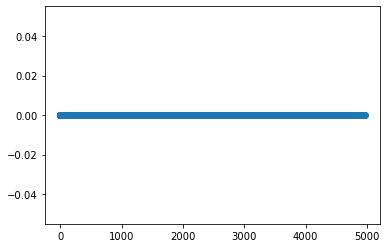

In [29]:
plt.scatter(x_length, srho_daily)
plt.show()

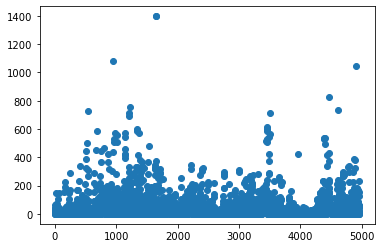

In [30]:
plt.scatter(x_length, rmse_daily)

In [31]:
#HUC2_shp = geopandas.read_file('/glade/work/tijerina/Shape_Files/CONUS2_HUC2_boundaries_clipped.shp')

In [32]:
# HUC2_shp.to_crs("EPSG:3395")
# HUC2_shp.plot()

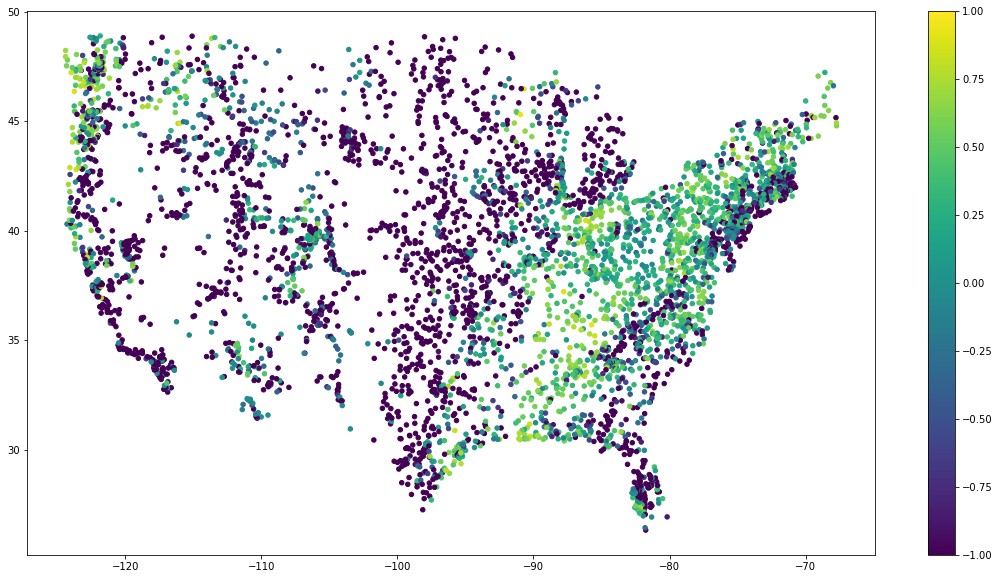

In [35]:
fig = plt.figure(figsize=(19,10), dpi=72)
plt.scatter(stats_df.longitude,stats_df.latitude, c=stats_df.r2, s=20, vmin = -1, vmax = 1)
plt.colorbar()
plt.show()

In [34]:
stats_df.r2.min()

-1.1245464674085751e+50

In [ ]:


ax.scatter(usgs_daily_flow['daily mean'], CONUS2_daily_flow['daily mean'], color = 'dimgrey')
ax.plot(range(1000), color = 'lightcoral')
plt.ylabel('PFCLM flow (cms)',fontsize=18)
plt.xlabel('USGS flow (cms)',fontsize=18)
plt.title('Daily mean flow comparison, October WY2003 (cms)',fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
# square plot
ax.set_aspect('equal', adjustable='box')
#plt.savefig(f'{plot_dir}/Oct_WY2003_daily_mean_flow_comparison_scatter.png')


